## Preparing the data 
Following the steps from https://www.geeksforgeeks.org/disease-prediction-using-machine-learning/ 

In this section we will load the training data, clean it and prepare for training.

In [1]:
#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline


In [3]:
TRAIN_FILE = 'dataset/disease_training.csv'

data = pd.read_csv(TRAIN_FILE)
print(data.shape)
# data is an array of number. 
#   .isnull() will covert each cell into 1 if null, else 0.  
#   .sum() will add all the rows
print(data.isnull().sum())

# Note that there is a columns with all missing values. In csv file you can see an extra column got added to the end. 
# Let's drop the extra column.  By default, dropna(..) removes any row with missing values. 
#    With "axis=1", panda will drop any columns that have missing values. 
data = data.dropna(axis = 1)

print('\nShape = rows, cols')
print(data.shape)


(4920, 134)
itching                    0
skin_rash                  0
nodal_skin_eruptions       0
continuous_sneezing        0
shivering                  0
                        ... 
blister                    0
red_sore_around_nose       0
yellow_crust_ooze          0
prognosis                  0
Unnamed: 133            4920
Length: 134, dtype: int64

Shape = rows, cols
(4920, 133)


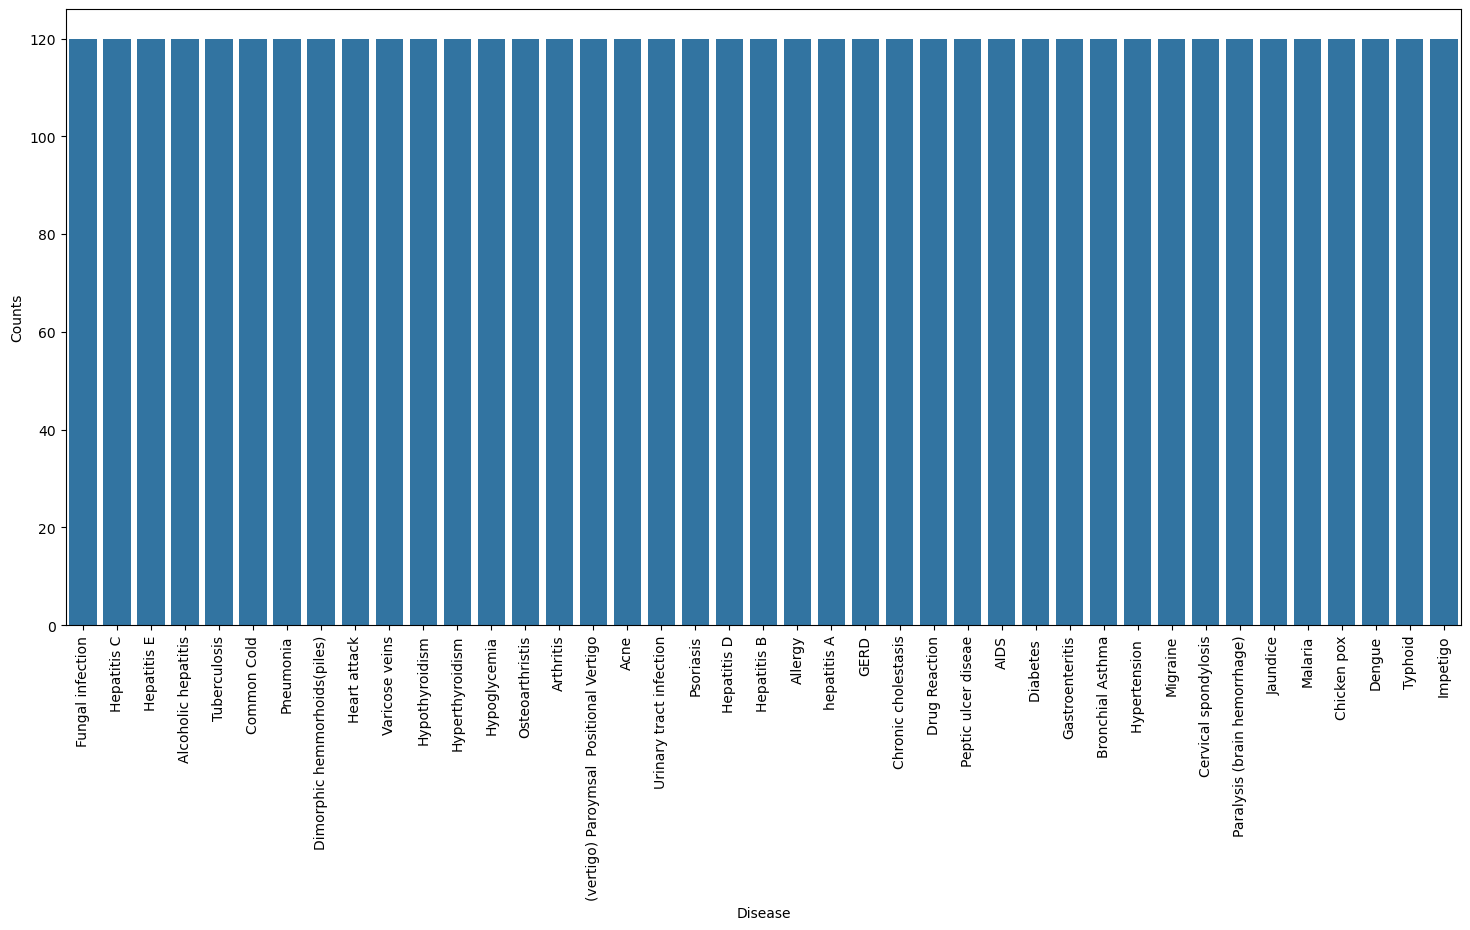

In [4]:
# Checking whether the dataset is balanced or not
disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease": disease_counts.index,
    "Counts": disease_counts.values
})

plt.figure(figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()


The plot above shows that we have a balanced data-set. We have equal samples for each disease.  
Now we will use the label encoder to numerify the disease. 
                                                                            

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

Now we will partition the data set into training and validation.  

First we split data into two: X contains all the input features, "y" contains the prognosis.  
Then we will split both the set using train_test_split(..). We are creating a validation set here, even though the function is called train_test_split(...)  
Note we set test_size to 20% (0.2). And we specify a seed for random_state for reproducability. 

In [6]:
X = data.iloc[:,:-1]
y = data.iloc[:, -1]
X_train, X_valid, y_train, y_valid =train_test_split(
  X, y, test_size = 0.2, random_state = 24)

print(f"Training  : {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_valid.shape}, {y_valid.shape}")

Training  : (3936, 132), (3936,)
Validation: (984, 132), (984,)


## Using K-Fold Cross-Validation for model selection 

cross_val_score will run the K-fold with 10 folds (cv=10). The data set is split into 10 equal part (folds). One fold is designated the test fold and other 9 are used for training. The process is repeated 10 times with each fold being the test fold. The scores from 10 runs are averaged to provide a more robust estimate.  
We use n_jobs = -1 to use all available cpu-cores. 


Note that we are not training yet, but rather picking a model to use. So we use the whole set (X,y) instead of just the training set (X_train, y_train).  

In [7]:
# Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
    # accuracy_score is calling the model (estimator) to predict values for all rows in X, 
    #   and comparing the values with the true value (y). 
    # accuracy = correct prediction / total instances
    return accuracy_score(y, estimator.predict(X))  

# Initializing Models
models = {
    "SVC":SVC(),
    "Gaussian NB":GaussianNB(),
    "Random Forest":RandomForestClassifier(random_state=18)
}

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, X, y, cv = 10,    # use 10 fold
                             n_jobs = -1,             # use all cores 
                             scoring = cv_scoring)     
    print("=="*30)
    print(model_name)
    print(f"Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")


SVC
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Gaussian NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Random Forest
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0


## Training and validation 

Now we will train each model and validate with the validation set. All models show a 100% accuracy.
Confusion matris shows actual value on Y-axis and predicated on X-axis. We can see that all predicted values are the same as actual values. The number on the diagnoal is the number of samples with this prognosis in the validation data set. 

Accuracy on train data by SVM Classifier: 100.0
Accuracy on validation data by SVM Classifier: 100.0


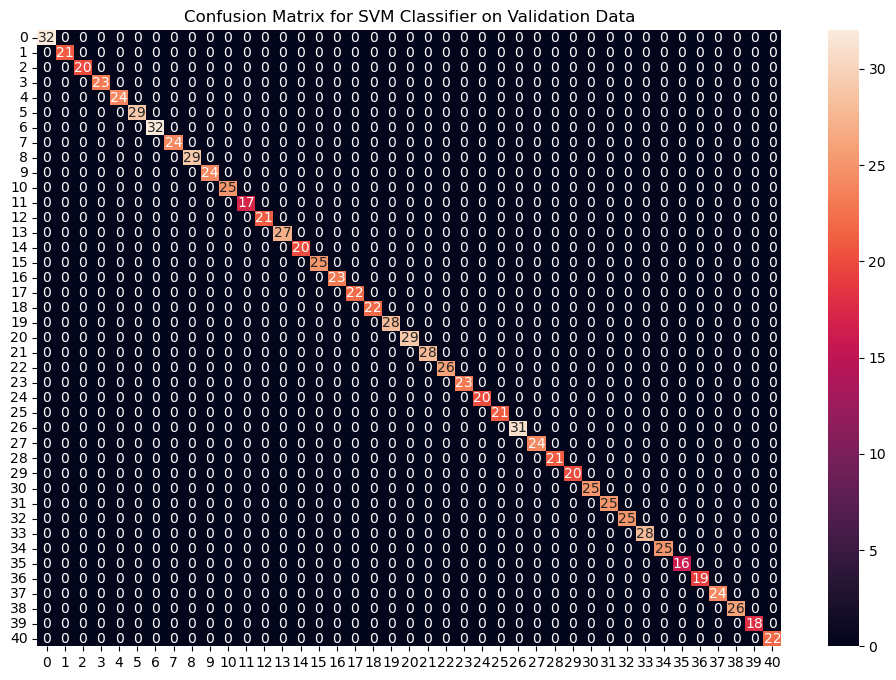

Accuracy on train data by Naive Bayes Classifier: 100.0
Accuracy on validation data by Naive Bayes Classifier: 100.0


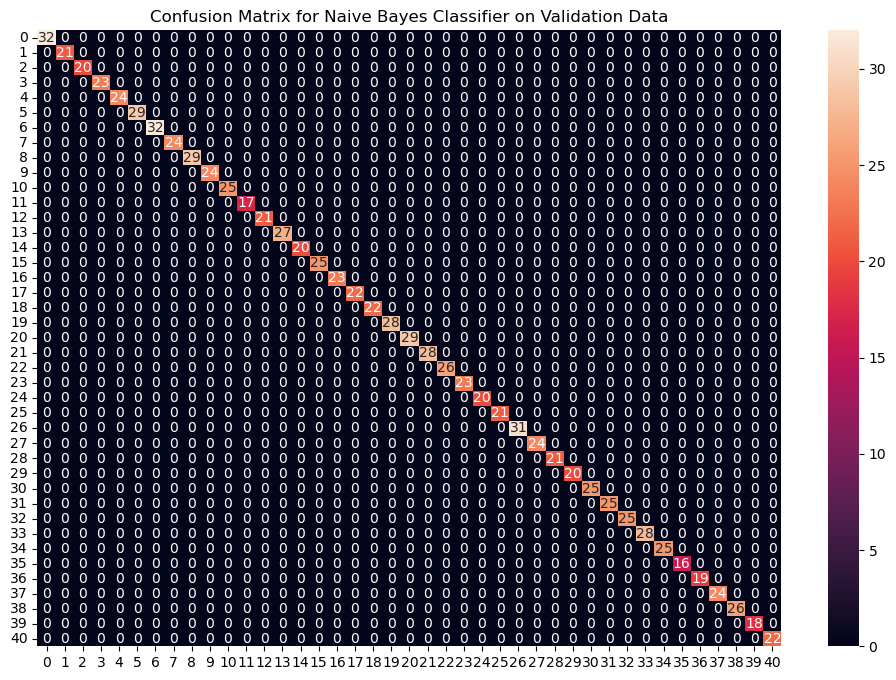

Accuracy on train data by Random Forest Classifier: 100.0
Accuracy on validation data by Random Forest Classifier: 100.0


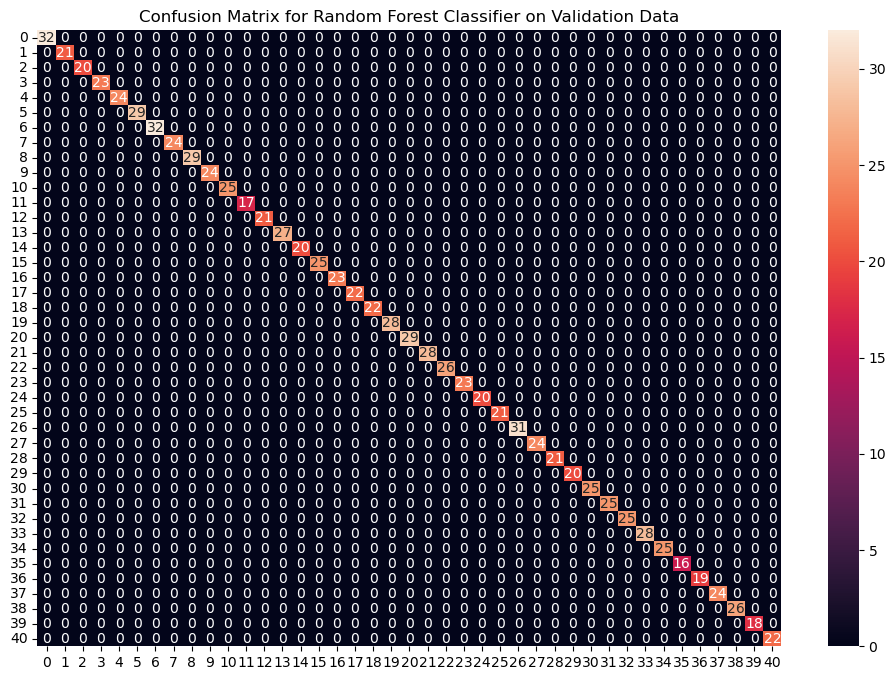

In [8]:
# Training and validating SVM Classifier
#
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_valid)

print(f"Accuracy on train data by SVM Classifier\
: {accuracy_score(y_train, svm_model.predict(X_train))*100}")

print(f"Accuracy on validation data by SVM Classifier\
: {accuracy_score(y_valid, preds)*100}")
cf_matrix = confusion_matrix(y_valid, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for SVM Classifier on Validation Data")
plt.show()

#
# Training and validating Naive Bayes Classifier
#
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
preds = nb_model.predict(X_valid)
print(f"Accuracy on train data by Naive Bayes Classifier\
: {accuracy_score(y_train, nb_model.predict(X_train))*100}")

print(f"Accuracy on validation data by Naive Bayes Classifier\
: {accuracy_score(y_valid, preds)*100}")
cf_matrix = confusion_matrix(y_valid, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Validation Data")
plt.show()

# Training and validating Random Forest Classifier
rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_valid)
print(f"Accuracy on train data by Random Forest Classifier\
: {accuracy_score(y_train, rf_model.predict(X_train))*100}")

print(f"Accuracy on validation data by Random Forest Classifier\
: {accuracy_score(y_valid, preds)*100}")

cf_matrix = confusion_matrix(y_valid, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier on Validation Data")
plt.show()


## Full training and testing 
We trained and evaluted 3 models: svm_model, nb_model and rf_model.   
Now we will train these models using the whole training set, and confirm against the testing data set that we haven't used until now. 

In [9]:
!pip install scipy

Accuracy on Test dataset by the combined model: 100.0


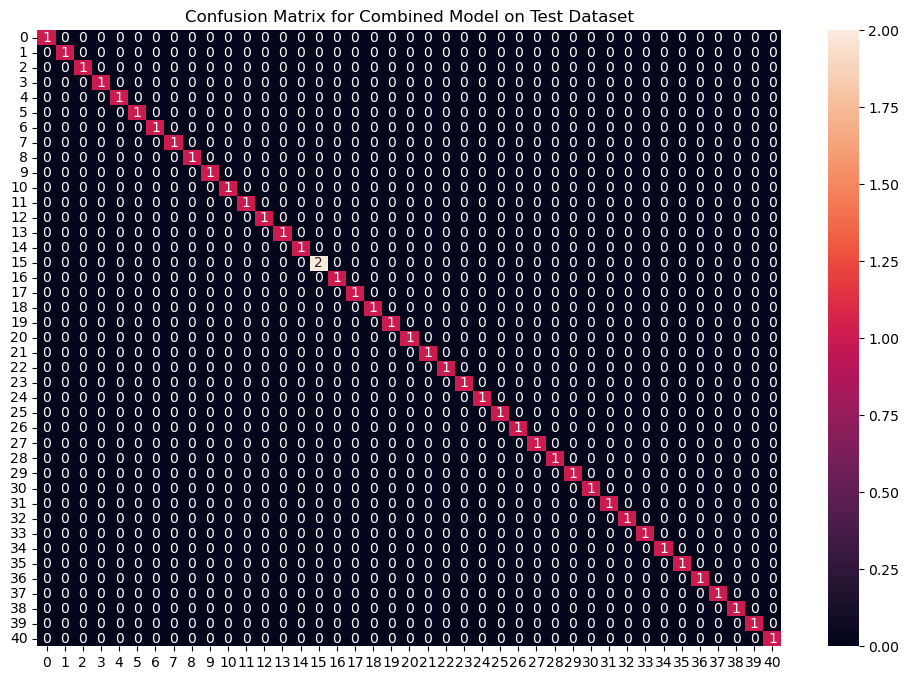

In [10]:

# Training the models on whole data
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_svm_model.fit(X, y)
final_nb_model.fit(X, y)
final_rf_model.fit(X, y)

# Reading the test data
test_data = pd.read_csv("./dataset/disease_testing.csv").dropna(axis=1)

test_X = test_data.iloc[:, :-1]
# Recall that we created a LabelEncoder earlier in the notebook. We will use that to convert 
#  the last column (prognosis) into a number. 
test_Y = encoder.transform(test_data.iloc[:, -1])

# Making prediction by take mode of predictions 
# made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)

from scipy import stats

# stats.mode basically picks the value that happens most often out of the 3 predictions. 
final_preds = [stats.mode([i,j,k])[0] for i,j,k in zip(svm_preds, nb_preds, rf_preds)]

print(f"Accuracy on Test dataset by the combined model: {accuracy_score(test_Y, final_preds)*100}")

cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))

sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()


## Create a function that uses the model 

We have a model that we like. We will now put that into a funciton that can be used. 

In [11]:
symptoms = X.columns.values
print(symptoms[0:3])  # symptoms is the row with the column header

# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

# Symptom as a key is now pointing to the column-index. Symptoms have been 
#  transformed e.g.  skin_rash --> Skin Rash
#   
print('Skin Rash index = ', symptom_index['Skin Rash'])

data_dict = {
    "symptom_index":symptom_index,
    "predictions_classes":encoder.classes_
}


['itching' 'skin_rash' 'nodal_skin_eruptions']
Skin Rash index =  1


In [12]:
# Defining the Function
# Input: string containing symptoms separated by commas
# Output: Generated predictions by models
def predictDisease(symptoms):
    symptoms = symptoms.split(",")
    
    # creating input data for the models
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1
        
    # reshaping the input data and converting it
    # into suitable format for model predictions
    input_data = np.array(input_data).reshape(1,-1)
    #print(input_data)

    # I got a warning that the model was training with column headings but the input doesn't have heading. 
    # adding this line to add columns headings. 
    input_data = pd.DataFrame(input_data, columns = X.columns.values)
    #print(input_data)

    # generating individual outputs
    rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
    nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
    
    # making final prediction by taking mode of all predictions
    # Use statistics.mode instead of scipy.stats.mode
    import statistics
    final_prediction = statistics.mode([rf_prediction, nb_prediction, svm_prediction])
    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": svm_prediction,
        "final_prediction":final_prediction
    }
    return predictions


In [13]:
import pprint
# Testing the function
#pprint.pprint(predictDisease("Itching,Shivering,Chills"))
pprint.pprint(predictDisease("Chills"))


{'final_prediction': 'Allergy',
 'naive_bayes_prediction': 'Allergy',
 'rf_model_prediction': 'Allergy',
 'svm_model_prediction': 'Allergy'}
